In [3]:
import os
#import gzip
#import six.moves.cPickle as pickle
from keras.models import Sequential, model_from_json,model_from_yaml
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adagrad, Adadelta, Adamax

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import pywt
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from scipy import ndimage, stats

In [6]:
from skimage import feature
import numpy as np
 
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
 
        # return the histogram of Local Binary Patterns
        return hist

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [8]:
def image_statistics(Zin):
    #Input: Z, a 2D array, hopefully containing some sort of peak
    #Output: cx,cy,sx,sy,skx,sky,kx,ky
    #cx and cy are the coordinates of the centroid
    #sx and sy are the stardard deviation in the x and y directions
    #skx and sky are the skewness in the x and y directions
    #kx and ky are the Kurtosis in the x and y directions
    #Note: this is not the excess kurtosis. For a normal distribution
    #you expect the kurtosis will be 3.0. Just subtract 3 to get the
    #excess kurtosis.
    
    Z = Zin + Zin.min()

    h,w = np.shape(Z)

    x = range(w)
    y = range(h)


    #calculate projections along the x and y axes
    yp = np.sum(Z,axis=1)
    xp = np.sum(Z,axis=0)

    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)

    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2

    sx = np.sqrt( np.sum(x2*xp)/np.sum(xp) )
    sy = np.sqrt( np.sum(y2*yp)/np.sum(yp) )

    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3

    skx = np.sum(xp*x3)/(np.sum(xp) * sx**3)
    sky = np.sum(yp*y3)/(np.sum(yp) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    kx = np.sum(xp*x4)/(np.sum(xp) * sx**4)
    ky = np.sum(yp*y4)/(np.sum(yp) * sy**4)


    return cx,cy,sx,sy,skx,sky,kx,ky

In [9]:
def plot_hist(ax, lbp_im):
    n_bins = np.size(lbp_im) 
    plt.bar(x=range(0, int(n_bins)), height=lbp_im.ravel(), color='r')
    ax.set_xlabel('LBP uniform patterns', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.grid(True)
#    ax.xaxis.label.set_size(20)

def process_images(img_folder):
    X_train = []
    y_train = []
    for idx, dirs in enumerate(os.listdir(img_folder)):
        print(idx, dirs)
        actual_folder = os.path.join(img_folder,dirs)
        for name in os.listdir(actual_folder):
            print('-- ',name)
    
            im = cv2.imread(os.path.join(actual_folder,name))
#            im_denoised = cv2.fastNlMeansDenoisingColored(im,None,1,10,7,21)
#            im_noise = im - im_denoised
#            im_gray_noise = cv2.cvtColor(im_noise, cv2.COLOR_BGR2GRAY)
#            
#            fig, ax = plt.subplots (1,3, sharex = False)
#            for axi in ax: axi.axis('off')
#            ax[0].imshow(im)
#            ax[1].imshow(im_denoised)
#            ax[2].imshow(im_noise)
#            fig.tight_layout()
            
            
            level=4
            distances = [1] #[1, 2, 3]
            angles = [0] #[0, np.pi/4, np.pi/2, 3*np.pi/4]
            properties = ['energy', 'homogeneity', 'contrast', 'energy', 'correlation']
            win_rows, win_cols = 3, 3
            sigma0 = 1e5  # degree of noise supression 

            features_WAV = np.array([])            
            coeffs_RGB = coeffs_RGB_filtered = [pywt.wavedec2(im[:,:,i], 'db8', level=level) for i in range(0,3)]
            im_filtered = np.empty(im.shape,dtype='uint8')
            for i_rgb in range(0,3):
                for i_level in range(1,level+1):
#                    print(i_level)
                    im_denoised = []
                    for i_vhd in range(0,3):
                        im_actual = coeffs_RGB[i_rgb][i_level][i_vhd]
                        
                        # High-order wavelet features
                        features_WAV = np.append(features_WAV, list(image_statistics(im_actual)))
                        
                        # Wavelet coefficient co-occurrence statistics
#                        im_gray_noise = cv2.cvtColor(coeffs_RGB[i_rgb][i_level][i_vhd], cv2.COLOR_BGR2GRAY)
#                        glcm = greycomatrix(coeffs_RGB[i_rgb][i_level][i_vhd], distances=distances, angles=angles, symmetric=True, normed=True)
#                        features_WAV = np.append(features_WAV, [greycoprops(coeffs_RGB[i_rgb][i_level][i_vhd], prop).ravel() for prop in properties])
#                        features_WAV = np.append(features_WAV, shannon_entropy(im_actual))
                        
                        # SPN   https://stackoverflow.com/questions/16107671/variance-image-in-python-using-gdal-and-a-running-window-approach
                        win_mean = ndimage.uniform_filter(im_actual,(win_rows,win_cols))
                        win_sqr_mean = ndimage.uniform_filter(im_actual**2,(win_rows,win_cols))
                        win_var = win_sqr_mean - win_mean**2
                          
                        im_denoised.append( im_actual*win_var**2/(win_var**2+sigma0) )
                    
                    coeffs_RGB_filtered[i_rgb][i_level] = tuple(im_denoised)
                im_filtered[:,:,i_rgb] = pywt.waverec2(coeffs_RGB_filtered[i_rgb], 'db8')

            im_noise = im-im_filtered
            
#            fig, ax = plt.subplots (1,3, sharex = False)
#            for axi in ax: axi.axis('off')
#            ax[0].imshow(im)
#            ax[1].imshow(im_filtered)
#            ax[2].imshow(im_noise)
#            fig.tight_layout()
            
            
#            lbp = LocalBinaryPatterns(24, 8)
#            lbp_im = lbp.describe(cv2.cvtColor(im_noise, cv2.COLOR_BGR2GRAY))
#            fig, ax = plt.subplots (1, figsize=(6, 4), sharex = True)
#            plot_hist(ax,lbp_im)
#            plt.tight_layout()
            
            features_SPN = np.array([])
            features_LBP = np.array([])
            lbp = LocalBinaryPatterns(24, 8)
            coeffs_RGB = [pywt.wavedec2(im_noise[:,:,i], 'db8', level=1) for i in range(0,3)]
            for i_rgb in range(0,3):
                for i_vhd in range(0,3):
                    for i_mom in range(1,9):
                        features_SPN = np.append(features_SPN, stats.moment( coeffs_RGB[i_rgb][1][i_vhd].flatten(), moment=i_mom))
                    features_LBP = np.append(features_LBP, lbp.describe(coeffs_RGB[i_rgb][1][i_vhd]))
                      
            X_train.append(np.concatenate((features_WAV,features_SPN,features_LBP)).tolist())
            y_train.append(idx)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # REMOVE INVALID FEATURES
    bool_invalid_Features = np.any(np.isfinite(X_train), axis=0)
    idx_invalid_Features = np.where(np.logical_not( bool_invalid_Features ))
    X_train = np.delete(X_train, idx_invalid_Features, axis=1)
    
    return (X_train, y_train)

In [10]:
def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid'))
    model.summary()
    # compile the model
#    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#    adamax = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

def build_neuralnetwork_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.summary()
    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['binary_accuracy'])
    return model


def train_model(X_train, y_train):
    # Split the data into a training set and a test set
    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
      
    # NORMALIZE DATA
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_norm = scaler.fit_transform(X_train)
    #X_retransformed = scaler.inverse_transform(X_transformed)
     
    batch_size = X_train_norm.shape[0]
    nb_classes = y_train.max() +1
    nb_epoch = 300
    nb_trains = 100
    input_dim = X_train_norm.shape[1]
       
    print(X_train_norm.shape[0], 'train samples')
    
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
       
    model = []
    history = []
    score = []
    earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
    for i_class in range(nb_classes):
        model.append(build_logistic_model(input_dim, 1))
    #    model.append(build_neuralnetwork_model(input_dim, 1))
        for i_train in range(nb_trains):
            model[i_class].fit(X_train_norm, Y_train[:,i_class],
                                batch_size=batch_size, epochs=nb_epoch,
                                verbose=1, validation_split=0.4,
                                callbacks=[earlyStopping])
        score.append(model[i_class].evaluate(X_train_norm, Y_train[:,i_class], verbose=0))
    return model, scaler

In [13]:
experiment_name = 'Thyroid_Combine'
extract_features = True
train_new_model = True
img_folder = 'data/combined/train/'


save_folder = os.path.join(os.getcwd(), experiment_name)

if extract_features:
    (X_train, y_train) = process_images(img_folder)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    np.save(os.path.join(save_folder,'X_train') , X_train)
    np.save(os.path.join(save_folder,'y_train') , y_train)
else:
    X_train = np.load(os.path.join(save_folder,'X_train.npy'))
    y_train = np.load(os.path.join(save_folder,'y_train.npy'))

0 benign
--  100_1.png
--  100_2.png
--  100_3.png
--  100_4.png
--  100_5.png
--  100_6.png
--  100_7.png
--  100_8.png
--  100_9.png
--  101_1.png
--  101_2.png
--  101_3.png
--  101_4.png
--  101_5.png
--  101_6.png
--  101_7.png
--  101_8.png
--  101_9.png
--  102_1.png
--  102_2.png
--  102_3.png
--  102_4.png
--  102_5.png
--  102_6.png
--  102_7.png
--  102_8.png
--  102_9.png
--  103_1.png
--  103_2.png
--  103_3.png
--  103_4.png
--  103_5.png
--  103_6.png
--  103_7.png
--  103_8.png
--  103_9.png
--  104_1.png
--  104_2.png
--  104_3.png
--  104_4.png
--  104_5.png
--  104_6.png
--  104_7.png
--  104_8.png
--  104_9.png
--  105_1.png
--  105_2.png
--  105_3.png
--  105_4.png
--  105_5.png
--  105_6.png
--  105_7.png
--  105_8.png
--  105_9.png
--  106_1.png
--  106_2.png
--  106_3.png
--  106_4.png
--  106_5.png
--  106_6.png
--  106_7.png
--  106_8.png
--  106_9.png
--  108_1.png
--  108_2.png
--  108_3.png
--  108_4.png
--  108_5.png
--  108_6.png
--  108_7.png
--  108_8.p

--  22_7.png
--  22_8.png
--  22_9.png
--  23_1.png
--  23_2.png
--  23_3.png
--  23_4.png
--  23_5.png
--  23_6.png
--  23_7.png
--  23_8.png
--  23_9.png
--  247_1p11.jpg
--  247_1p12.jpg
--  247_1p13.jpg
--  247_1p14.jpg
--  247_1p15.jpg
--  247_1p16.jpg
--  247_1p17.jpg
--  247_1p21.jpg
--  247_1p22.jpg
--  247_1p23.jpg
--  247_1p24.jpg
--  247_1p25.jpg
--  247_1p26.jpg
--  247_1p27.jpg
--  24_1.png
--  24_2.png
--  24_3.png
--  24_4.png
--  24_5.png
--  24_6.png
--  24_7.png
--  24_8.png
--  24_9.png
--  25_1.png
--  25_1p11.jpg
--  25_1p12.jpg
--  25_1p13.jpg
--  25_1p14.jpg
--  25_1p15.jpg
--  25_1p16.jpg
--  25_1p17.jpg
--  25_2.png
--  25_3.png
--  25_4.png
--  25_5.png
--  25_6.png
--  25_7.png
--  25_8.png
--  25_9.png
--  26_1.png
--  26_2.png
--  26_3.png
--  26_4.png
--  26_5.png
--  26_6.png
--  26_7.png
--  26_8.png
--  26_9.png
--  270_1p11.jpg
--  270_1p12.jpg
--  270_1p13.jpg
--  270_1p14.jpg
--  270_1p15.jpg
--  270_1p16.jpg
--  270_1p17.jpg
--  270_1p21.jpg
--  270

--  43_3.png
--  43_4.png
--  43_5.png
--  43_6.png
--  43_7.png
--  43_8.png
--  43_9.png
--  49_1.png
--  49_2.png
--  49_3.png
--  49_4.png
--  49_5.png
--  49_6.png
--  49_7.png
--  49_8.png
--  49_9.png
--  4_1.png
--  4_2.png
--  4_3.png
--  4_4.png
--  4_5.png
--  4_6.png
--  4_7.png
--  4_8.png
--  4_9.png
--  50_1.png
--  50_2.png
--  50_3.png
--  50_4.png
--  50_5.png
--  50_6.png
--  50_7.png
--  50_8.png
--  50_9.png
--  51_1.png
--  51_1p11.jpg
--  51_1p12.jpg
--  51_1p13.jpg
--  51_1p14.jpg
--  51_1p15.jpg
--  51_1p16.jpg
--  51_1p17.jpg
--  51_2.png
--  51_3.png
--  51_4.png
--  51_5.png
--  51_6.png
--  51_7.png
--  51_8.png
--  51_9.png
--  52_1.png
--  52_2.png
--  52_3.png
--  52_4.png
--  52_5.png
--  52_6.png
--  52_7.png
--  52_8.png
--  52_9.png
--  53_1.png
--  53_2.png
--  53_3.png
--  53_4.png
--  53_5.png
--  53_6.png
--  53_7.png
--  53_8.png
--  53_9.png
--  54_1.png
--  54_2.png
--  54_3.png
--  54_4.png
--  54_5.png
--  54_6.png
--  54_7.png
--  54_8.png


--  11_1p13.jpg
--  11_1p14.jpg
--  11_1p15.jpg
--  11_1p16.jpg
--  11_1p17.jpg
--  121_1p11.jpg
--  121_1p12.jpg
--  121_1p13.jpg
--  121_1p14.jpg
--  121_1p15.jpg
--  121_1p16.jpg
--  121_1p17.jpg
--  121_1p21.jpg
--  121_1p22.jpg
--  121_1p23.jpg
--  121_1p24.jpg
--  121_1p25.jpg
--  121_1p26.jpg
--  121_1p27.jpg
--  122_1p11.jpg
--  122_1p12.jpg
--  122_1p13.jpg
--  122_1p14.jpg
--  122_1p15.jpg
--  122_1p16.jpg
--  122_1p17.jpg
--  122_1p21.jpg
--  122_1p22.jpg
--  122_1p23.jpg
--  122_1p24.jpg
--  122_1p25.jpg
--  122_1p26.jpg
--  122_1p27.jpg
--  122_2p11.jpg
--  122_2p12.jpg
--  122_2p13.jpg
--  122_2p14.jpg
--  122_2p15.jpg
--  122_2p16.jpg
--  122_2p17.jpg
--  122_2p21.jpg
--  122_2p22.jpg
--  122_2p23.jpg
--  122_2p24.jpg
--  122_2p25.jpg
--  122_2p26.jpg
--  122_2p27.jpg
--  123_1.png
--  123_1p11.jpg
--  123_1p12.jpg
--  123_1p13.jpg
--  123_1p14.jpg
--  123_1p15.jpg
--  123_1p16.jpg
--  123_1p17.jpg
--  123_1p21.jpg
--  123_1p22.jpg
--  123_1p23.jpg
--  123_1p24.jpg
--  1

--  176_1p12.jpg
--  176_1p13.jpg
--  176_1p14.jpg
--  176_1p15.jpg
--  176_1p16.jpg
--  176_1p17.jpg
--  177_1p11.jpg
--  177_1p12.jpg
--  177_1p13.jpg
--  177_1p14.jpg
--  177_1p15.jpg
--  177_1p16.jpg
--  177_1p17.jpg
--  177_2p11.jpg
--  177_2p12.jpg
--  177_2p13.jpg
--  177_2p14.jpg
--  177_2p15.jpg
--  177_2p16.jpg
--  177_2p17.jpg
--  178_1p11.jpg
--  178_1p12.jpg
--  178_1p13.jpg
--  178_1p14.jpg
--  178_1p15.jpg
--  178_1p16.jpg
--  178_1p17.jpg
--  179_1p11.jpg
--  179_1p12.jpg
--  179_1p13.jpg
--  179_1p14.jpg
--  179_1p15.jpg
--  179_1p16.jpg
--  179_1p17.jpg
--  179_1p21.jpg
--  179_1p22.jpg
--  179_1p23.jpg
--  179_1p24.jpg
--  179_1p25.jpg
--  179_1p26.jpg
--  179_1p27.jpg
--  180_1p11.jpg
--  180_1p12.jpg
--  180_1p13.jpg
--  180_1p14.jpg
--  180_1p15.jpg
--  180_1p16.jpg
--  180_1p17.jpg
--  180_1p21.jpg
--  180_1p22.jpg
--  180_1p23.jpg
--  180_1p24.jpg
--  180_1p25.jpg
--  180_1p26.jpg
--  180_1p27.jpg
--  184_1p11.jpg
--  184_1p12.jpg
--  184_1p13.jpg
--  184_1p14.j

--  228_1p13.jpg
--  228_1p14.jpg
--  228_1p15.jpg
--  228_1p16.jpg
--  228_1p17.jpg
--  231_1p11.jpg
--  231_1p12.jpg
--  231_1p13.jpg
--  231_1p14.jpg
--  231_1p15.jpg
--  231_1p16.jpg
--  231_1p17.jpg
--  231_1p21.jpg
--  231_1p22.jpg
--  231_1p23.jpg
--  231_1p24.jpg
--  231_1p25.jpg
--  231_1p26.jpg
--  231_1p27.jpg
--  233_1p11.jpg
--  233_1p12.jpg
--  233_1p13.jpg
--  233_1p14.jpg
--  233_1p15.jpg
--  233_1p16.jpg
--  233_1p17.jpg
--  233_2p11.jpg
--  233_2p12.jpg
--  233_2p13.jpg
--  233_2p14.jpg
--  233_2p15.jpg
--  233_2p16.jpg
--  233_2p17.jpg
--  236_1p11.jpg
--  236_1p12.jpg
--  236_1p13.jpg
--  236_1p14.jpg
--  236_1p15.jpg
--  236_1p16.jpg
--  236_1p17.jpg
--  236_1p21.jpg
--  236_1p22.jpg
--  236_1p23.jpg
--  236_1p24.jpg
--  236_1p25.jpg
--  236_1p26.jpg
--  236_1p27.jpg
--  23_1p11.jpg
--  23_1p12.jpg
--  23_1p13.jpg
--  23_1p14.jpg
--  23_1p15.jpg
--  23_1p16.jpg
--  23_1p17.jpg
--  242_1p11.jpg
--  242_1p12.jpg
--  242_1p13.jpg
--  242_1p14.jpg
--  242_1p15.jpg
--  

--  294_3p16.jpg
--  294_3p17.jpg
--  295_1p11.jpg
--  295_1p12.jpg
--  295_1p13.jpg
--  295_1p14.jpg
--  295_1p15.jpg
--  295_1p16.jpg
--  295_1p17.jpg
--  296_1p11.jpg
--  296_1p12.jpg
--  296_1p13.jpg
--  296_1p14.jpg
--  296_1p15.jpg
--  296_1p16.jpg
--  296_1p17.jpg
--  296_2p11.jpg
--  296_2p12.jpg
--  296_2p13.jpg
--  296_2p14.jpg
--  296_2p15.jpg
--  296_2p16.jpg
--  296_2p17.jpg
--  296_3p11.jpg
--  296_3p12.jpg
--  296_3p13.jpg
--  296_3p14.jpg
--  296_3p15.jpg
--  296_3p16.jpg
--  296_3p17.jpg
--  296_4p11.jpg
--  296_4p12.jpg
--  296_4p13.jpg
--  296_4p14.jpg
--  296_4p15.jpg
--  296_4p16.jpg
--  296_4p17.jpg
--  296_5p11.jpg
--  296_5p12.jpg
--  296_5p13.jpg
--  296_5p14.jpg
--  296_5p15.jpg
--  296_5p16.jpg
--  296_5p17.jpg
--  297_1p11.jpg
--  297_1p12.jpg
--  297_1p13.jpg
--  297_1p14.jpg
--  297_1p15.jpg
--  297_1p16.jpg
--  297_1p17.jpg
--  298_1p11.jpg
--  298_1p12.jpg
--  298_1p13.jpg
--  298_1p14.jpg
--  298_1p15.jpg
--  298_1p16.jpg
--  298_1p17.jpg
--  299_1p11.j

--  360_2p12.jpg
--  360_2p13.jpg
--  360_2p14.jpg
--  360_2p15.jpg
--  360_2p16.jpg
--  360_2p17.jpg
--  363_1p11.jpg
--  363_1p12.jpg
--  363_1p13.jpg
--  363_1p14.jpg
--  363_1p15.jpg
--  363_1p16.jpg
--  363_1p17.jpg
--  367_1p11.jpg
--  367_1p12.jpg
--  367_1p13.jpg
--  367_1p14.jpg
--  367_1p15.jpg
--  367_1p16.jpg
--  367_1p17.jpg
--  367_2p11.jpg
--  367_2p12.jpg
--  367_2p13.jpg
--  367_2p14.jpg
--  367_2p15.jpg
--  367_2p16.jpg
--  367_2p17.jpg
--  368_1p11.jpg
--  368_1p12.jpg
--  368_1p13.jpg
--  368_1p14.jpg
--  368_1p15.jpg
--  368_1p16.jpg
--  368_1p17.jpg
--  36_1p11.jpg
--  36_1p12.jpg
--  36_1p13.jpg
--  36_1p14.jpg
--  36_1p15.jpg
--  36_1p16.jpg
--  36_1p17.jpg
--  370_1p11.jpg
--  370_1p12.jpg
--  370_1p13.jpg
--  370_1p14.jpg
--  370_1p15.jpg
--  370_1p16.jpg
--  370_1p17.jpg
--  371_1p11.jpg
--  371_1p12.jpg
--  371_1p13.jpg
--  371_1p14.jpg
--  371_1p15.jpg
--  371_1p16.jpg
--  371_1p17.jpg
--  371_2p11.jpg
--  371_2p12.jpg
--  371_2p13.jpg
--  371_2p14.jpg
--  

--  78_1p26.jpg
--  78_1p27.jpg
--  78_2.png
--  78_3.png
--  78_4.png
--  78_5.png
--  78_6.png
--  78_7.png
--  78_8.png
--  78_9.png
--  79_1p11.jpg
--  79_1p12.jpg
--  79_1p13.jpg
--  79_1p14.jpg
--  79_1p15.jpg
--  79_1p16.jpg
--  79_1p17.jpg
--  79_1p21.jpg
--  79_1p22.jpg
--  79_1p23.jpg
--  79_1p24.jpg
--  79_1p25.jpg
--  79_1p26.jpg
--  79_1p27.jpg
--  7_1p11.jpg
--  7_1p12.jpg
--  7_1p13.jpg
--  7_1p14.jpg
--  7_1p15.jpg
--  7_1p16.jpg
--  7_1p17.jpg
--  80_1p11.jpg
--  80_1p12.jpg
--  80_1p13.jpg
--  80_1p14.jpg
--  80_1p15.jpg
--  80_1p16.jpg
--  80_1p17.jpg
--  80_1p21.jpg
--  80_1p22.jpg
--  80_1p23.jpg
--  80_1p24.jpg
--  80_1p25.jpg
--  80_1p26.jpg
--  80_1p27.jpg
--  80_2p11.jpg
--  80_2p12.jpg
--  80_2p13.jpg
--  80_2p14.jpg
--  80_2p15.jpg
--  80_2p16.jpg
--  80_2p17.jpg
--  81_1p11.jpg
--  81_1p12.jpg
--  81_1p13.jpg
--  81_1p14.jpg
--  81_1p15.jpg
--  81_1p16.jpg
--  81_1p17.jpg
--  81_2p11.jpg
--  81_2p12.jpg
--  81_2p13.jpg
--  81_2p14.jpg
--  81_2p15.jpg
--  81_

In [14]:
if train_new_model:
    model, scaler = train_model(X_train, y_train)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    for idx,model_i in enumerate(model):
        json_string = model_i.to_json()
        open(os.path.join(save_folder,'model_'+str(idx)+'.json'), 'w').write(json_string)
        model_i.save_weights(os.path.join(save_folder,'model_'+str(idx)+'.h5'))
        with open(os.path.join(save_folder,'scaler.pkl'), 'wb') as f:
            pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)
else:
    model = []
    for idx in range(9):
        model.append(model_from_json(open(os.path.join(save_folder,'model_'+str(idx)+'.json')).read()))
        model[idx].load_weights(os.path.join(save_folder,'model_'+str(idx)+'.h5'))
    with open(os.path.join(save_folder,'scaler.pkl'), 'rb') as input:
        scaler = pickle.load(input)

4247 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 595       
Total params: 595
Trainable params: 595
Non-trainable params: 0
_________________________________________________________________
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 3s 1ms/step - loss: 0.7033 - binary_accuracy: 0.4847 - val_loss: 0.6407 - val_binary_accuracy: 0.7540
Epoch 2/300
2548/2548 [==============================] - 0s 13us/step - loss: 0.6857 - binary_accuracy: 0.6005 - val_loss: 0.7263 - val_binary_accuracy: 0.3420
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6731 - binary_accuracy: 0.5859 - val_loss: 0.8157 - val_binary_accuracy: 0.0736
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 

Epoch 4/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6333 - binary_accuracy: 0.6028 - val_loss: 0.7761 - val_binary_accuracy: 0.3567
Epoch 5/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6327 - binary_accuracy: 0.6079 - val_loss: 0.7684 - val_binary_accuracy: 0.3832
Epoch 6/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6321 - binary_accuracy: 0.6138 - val_loss: 0.7601 - val_binary_accuracy: 0.4161
Epoch 7/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6315 - binary_accuracy: 0.6197 - val_loss: 0.7524 - val_binary_accuracy: 0.4344
Epoch 8/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6310 - binary_accuracy: 0.6248 - val_loss: 0.7459 - val_binary_accuracy: 0.4509
Epoch 9/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6305 - binary_accuracy: 0.6287 - val_loss: 0.7414 - val_binary_accuracy: 0.4656
Epoch 10/300
2548/2548 [================

Epoch 7/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6136 - binary_accuracy: 0.6456 - val_loss: 0.7145 - val_binary_accuracy: 0.5633
Epoch 8/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6133 - binary_accuracy: 0.6444 - val_loss: 0.7132 - val_binary_accuracy: 0.5656
Epoch 9/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6130 - binary_accuracy: 0.6460 - val_loss: 0.7122 - val_binary_accuracy: 0.5668
Epoch 10/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6127 - binary_accuracy: 0.6460 - val_loss: 0.7115 - val_binary_accuracy: 0.5674
Epoch 11/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6125 - binary_accuracy: 0.6472 - val_loss: 0.7110 - val_binary_accuracy: 0.5686
Epoch 12/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6122 - binary_accuracy: 0.6468 - val_loss: 0.7107 - val_binary_accuracy: 0.5686
Epoch 13/300
2548/2548 [=============

Epoch 58/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6018 - binary_accuracy: 0.6566 - val_loss: 0.6880 - val_binary_accuracy: 0.6186
Epoch 59/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6016 - binary_accuracy: 0.6566 - val_loss: 0.6876 - val_binary_accuracy: 0.6192
Epoch 60/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6014 - binary_accuracy: 0.6566 - val_loss: 0.6872 - val_binary_accuracy: 0.6192
Epoch 61/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6012 - binary_accuracy: 0.6574 - val_loss: 0.6868 - val_binary_accuracy: 0.6198
Epoch 62/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6011 - binary_accuracy: 0.6574 - val_loss: 0.6864 - val_binary_accuracy: 0.6204
Epoch 63/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6009 - binary_accuracy: 0.6582 - val_loss: 0.6860 - val_binary_accuracy: 0.6210
Epoch 64/300
2548/2548 [==========

Epoch 109/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5939 - binary_accuracy: 0.6641 - val_loss: 0.6744 - val_binary_accuracy: 0.6457
Epoch 110/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5937 - binary_accuracy: 0.6641 - val_loss: 0.6742 - val_binary_accuracy: 0.6457
Epoch 111/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5936 - binary_accuracy: 0.6644 - val_loss: 0.6740 - val_binary_accuracy: 0.6463
Epoch 112/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5935 - binary_accuracy: 0.6648 - val_loss: 0.6739 - val_binary_accuracy: 0.6463
Epoch 113/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5933 - binary_accuracy: 0.6648 - val_loss: 0.6737 - val_binary_accuracy: 0.6457
Epoch 114/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5932 - binary_accuracy: 0.6648 - val_loss: 0.6735 - val_binary_accuracy: 0.6463
Epoch 115/300
2548/2548 [===

Epoch 160/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5878 - binary_accuracy: 0.6723 - val_loss: 0.6688 - val_binary_accuracy: 0.6598
Epoch 161/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5877 - binary_accuracy: 0.6719 - val_loss: 0.6687 - val_binary_accuracy: 0.6610
Epoch 162/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5876 - binary_accuracy: 0.6719 - val_loss: 0.6687 - val_binary_accuracy: 0.6610
Epoch 163/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5874 - binary_accuracy: 0.6719 - val_loss: 0.6686 - val_binary_accuracy: 0.6610
Epoch 164/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5873 - binary_accuracy: 0.6715 - val_loss: 0.6685 - val_binary_accuracy: 0.6610
Epoch 165/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5872 - binary_accuracy: 0.6711 - val_loss: 0.6685 - val_binary_accuracy: 0.6604
Epoch 166/300
2548/2548 [===

Epoch 211/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5826 - binary_accuracy: 0.6766 - val_loss: 0.6674 - val_binary_accuracy: 0.6604
Epoch 212/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5825 - binary_accuracy: 0.6762 - val_loss: 0.6674 - val_binary_accuracy: 0.6604
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5825 - binary_accuracy: 0.6762 - val_loss: 0.6674 - val_binary_accuracy: 0.6604
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5824 - binary_accuracy: 0.6766 - val_loss: 0.6674 - val_binary_accuracy: 0.6604
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5823 - binary_accuracy: 0.6766 - val_loss: 0.6675 - val_binary_accuracy: 0.6604
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5822 - binary_accura

Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5787 - binary_accuracy: 0.6797 - val_loss: 0.6681 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5786 - binary_accuracy: 0.6790 - val_loss: 0.6681 - val_binary_accuracy: 0.6645
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5785 - binary_accuracy: 0.6790 - val_loss: 0.6681 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5784 - binary_accuracy: 0.6794 - val_loss: 0.6682 - val_binary_accuracy: 0.6645
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5784 - binary_accuracy: 0.6797 - val_loss: 0.6682 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] -

Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5752 - binary_accuracy: 0.6813 - val_loss: 0.6696 - val_binary_accuracy: 0.6622
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5751 - binary_accuracy: 0.6817 - val_loss: 0.6696 - val_binary_accuracy: 0.6616
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5750 - binary_accuracy: 0.6817 - val_loss: 0.6696 - val_binary_accuracy: 0.6622
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5749 - binary_accuracy: 0.6817 - val_loss: 0.6697 - val_binary_accuracy: 0.6622
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5749 - binary_accuracy: 0.6813 - val_loss: 0.6697 - val_binary_accuracy: 0.6622
Epoch 2/300
2548/2548 [==============================] -

Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5720 - binary_accuracy: 0.6841 - val_loss: 0.6714 - val_binary_accuracy: 0.6651
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5719 - binary_accuracy: 0.6849 - val_loss: 0.6715 - val_binary_accuracy: 0.6645
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5719 - binary_accuracy: 0.6852 - val_loss: 0.6715 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5718 - binary_accuracy: 0.6860 - val_loss: 0.6715 - val_binary_accuracy: 0.6645
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5717 - binary_accuracy: 0.6860 - val_loss: 0.6716 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] -

Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.6624 - binary_accuracy: 0.5989 - val_loss: 0.7696 - val_binary_accuracy: 0.1630
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6604 - binary_accuracy: 0.5934 - val_loss: 0.7894 - val_binary_accuracy: 0.1077
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6585 - binary_accuracy: 0.5903 - val_loss: 0.8120 - val_binary_accuracy: 0.0618
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6570 - binary_accuracy: 0.5859 - val_loss: 0.8350 - val_binary_accuracy: 0.0318
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.6559 - binary_accuracy: 0.5805 - val_loss: 0.8559 - val_binary_accuracy: 0.0194
Epoch 2/300
2548/2548 [==============================] -

Epoch 6/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6271 - binary_accuracy: 0.6154 - val_loss: 0.7657 - val_binary_accuracy: 0.4002
Epoch 7/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6266 - binary_accuracy: 0.6205 - val_loss: 0.7621 - val_binary_accuracy: 0.4126
Epoch 8/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6261 - binary_accuracy: 0.6217 - val_loss: 0.7595 - val_binary_accuracy: 0.4220
Epoch 9/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6256 - binary_accuracy: 0.6268 - val_loss: 0.7578 - val_binary_accuracy: 0.4279
Epoch 10/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6252 - binary_accuracy: 0.6268 - val_loss: 0.7570 - val_binary_accuracy: 0.4326
Epoch 11/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6247 - binary_accuracy: 0.6283 - val_loss: 0.7571 - val_binary_accuracy: 0.4332
Train on 2548 samples, validate on 169

Epoch 42/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6076 - binary_accuracy: 0.6593 - val_loss: 0.7200 - val_binary_accuracy: 0.5662
Epoch 43/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6073 - binary_accuracy: 0.6593 - val_loss: 0.7195 - val_binary_accuracy: 0.5674
Epoch 44/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6070 - binary_accuracy: 0.6586 - val_loss: 0.7190 - val_binary_accuracy: 0.5686
Epoch 45/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6067 - binary_accuracy: 0.6589 - val_loss: 0.7184 - val_binary_accuracy: 0.5686
Epoch 46/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6064 - binary_accuracy: 0.6597 - val_loss: 0.7178 - val_binary_accuracy: 0.5697
Epoch 47/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.6061 - binary_accuracy: 0.6593 - val_loss: 0.7172 - val_binary_accuracy: 0.5715
Epoch 48/300
2548/2548 [==========

Epoch 93/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5960 - binary_accuracy: 0.6703 - val_loss: 0.6927 - val_binary_accuracy: 0.6215
Epoch 94/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5959 - binary_accuracy: 0.6703 - val_loss: 0.6923 - val_binary_accuracy: 0.6215
Epoch 95/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5957 - binary_accuracy: 0.6711 - val_loss: 0.6919 - val_binary_accuracy: 0.6221
Epoch 96/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5955 - binary_accuracy: 0.6719 - val_loss: 0.6915 - val_binary_accuracy: 0.6221
Epoch 97/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5953 - binary_accuracy: 0.6719 - val_loss: 0.6912 - val_binary_accuracy: 0.6221
Epoch 98/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5952 - binary_accuracy: 0.6719 - val_loss: 0.6908 - val_binary_accuracy: 0.6227
Epoch 99/300
2548/2548 [==========

Epoch 144/300
2548/2548 [==============================] - 0s 12us/step - loss: 0.5886 - binary_accuracy: 0.6770 - val_loss: 0.6782 - val_binary_accuracy: 0.6374
Epoch 145/300
2548/2548 [==============================] - 0s 12us/step - loss: 0.5885 - binary_accuracy: 0.6770 - val_loss: 0.6780 - val_binary_accuracy: 0.6392
Epoch 146/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5884 - binary_accuracy: 0.6778 - val_loss: 0.6778 - val_binary_accuracy: 0.6392
Epoch 147/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5882 - binary_accuracy: 0.6778 - val_loss: 0.6776 - val_binary_accuracy: 0.6392
Epoch 148/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5881 - binary_accuracy: 0.6778 - val_loss: 0.6774 - val_binary_accuracy: 0.6398
Epoch 149/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5880 - binary_accuracy: 0.6778 - val_loss: 0.6772 - val_binary_accuracy: 0.6404
Epoch 150/300
2548/2548 [===

Epoch 195/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5831 - binary_accuracy: 0.6805 - val_loss: 0.6715 - val_binary_accuracy: 0.6504
Epoch 196/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5830 - binary_accuracy: 0.6809 - val_loss: 0.6714 - val_binary_accuracy: 0.6504
Epoch 197/300
2548/2548 [==============================] - 0s 13us/step - loss: 0.5829 - binary_accuracy: 0.6809 - val_loss: 0.6713 - val_binary_accuracy: 0.6516
Epoch 198/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5828 - binary_accuracy: 0.6813 - val_loss: 0.6713 - val_binary_accuracy: 0.6521
Epoch 199/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5827 - binary_accuracy: 0.6813 - val_loss: 0.6712 - val_binary_accuracy: 0.6539
Epoch 200/300
2548/2548 [==============================] - 0s 13us/step - loss: 0.5826 - binary_accuracy: 0.6817 - val_loss: 0.6711 - val_binary_accuracy: 0.6539
Epoch 201/300
2548/2548 [===

Epoch 246/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5786 - binary_accuracy: 0.6860 - val_loss: 0.6693 - val_binary_accuracy: 0.6580
Epoch 247/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5785 - binary_accuracy: 0.6860 - val_loss: 0.6692 - val_binary_accuracy: 0.6580
Epoch 248/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5784 - binary_accuracy: 0.6860 - val_loss: 0.6692 - val_binary_accuracy: 0.6580
Epoch 249/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5783 - binary_accuracy: 0.6860 - val_loss: 0.6692 - val_binary_accuracy: 0.6580
Epoch 250/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5782 - binary_accuracy: 0.6864 - val_loss: 0.6692 - val_binary_accuracy: 0.6580
Epoch 251/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5782 - binary_accuracy: 0.6868 - val_loss: 0.6692 - val_binary_accuracy: 0.6586
Epoch 252/300
2548/2548 [===

Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5749 - binary_accuracy: 0.6896 - val_loss: 0.6694 - val_binary_accuracy: 0.6622
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5748 - binary_accuracy: 0.6892 - val_loss: 0.6694 - val_binary_accuracy: 0.6627
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5747 - binary_accuracy: 0.6888 - val_loss: 0.6694 - val_binary_accuracy: 0.6627
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5747 - binary_accuracy: 0.6892 - val_loss: 0.6694 - val_binary_accuracy: 0.6627
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5746 - binary_accuracy: 0.6892 - val_loss: 0.6695 - val_binary_accuracy: 0.6627
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] -

Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5718 - binary_accuracy: 0.6896 - val_loss: 0.6706 - val_binary_accuracy: 0.6645
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5717 - binary_accuracy: 0.6896 - val_loss: 0.6706 - val_binary_accuracy: 0.6645
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5717 - binary_accuracy: 0.6896 - val_loss: 0.6706 - val_binary_accuracy: 0.6639
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5716 - binary_accuracy: 0.6900 - val_loss: 0.6707 - val_binary_accuracy: 0.6639
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5715 - binary_accuracy: 0.6900 - val_loss: 0.6707 - val_binary_accuracy: 0.6639
Epoch 2/300
2548/2548 [==============================] -

Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5690 - binary_accuracy: 0.6951 - val_loss: 0.6722 - val_binary_accuracy: 0.6686
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 10us/step - loss: 0.5689 - binary_accuracy: 0.6951 - val_loss: 0.6723 - val_binary_accuracy: 0.6680
Epoch 2/300
2548/2548 [==============================] - 0s 14us/step - loss: 0.5689 - binary_accuracy: 0.6943 - val_loss: 0.6723 - val_binary_accuracy: 0.6680
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5688 - binary_accuracy: 0.6943 - val_loss: 0.6723 - val_binary_accuracy: 0.6680
Epoch 2/300
2548/2548 [==============================] - 0s 11us/step - loss: 0.5688 - binary_accuracy: 0.6943 - val_loss: 0.6724 - val_binary_accuracy: 0.6680
Train on 2548 samples, validate on 1699 samples
Epoch 1/300
2548/2548 [==============================] -

In [16]:
X_train_norm = scaler.fit_transform(X_train)
y_pred = np.hstack( ( model[i_class].predict(X_train_norm) for i_class in range(2) ) )
y_pred = np.argmax(y_pred, axis=1)

In [17]:
accuracy = np.sum(y_train==y_pred)/len(y_train)

TRAINING ACCURACY: 68.2%
Normalized confusion matrix
[[0.75488215 0.24511785]
 [0.3577118  0.6422882 ]]


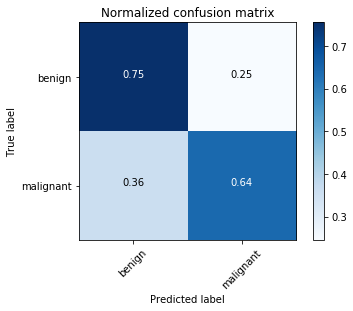

In [18]:
print('TRAINING ACCURACY: %0.1f%%' % (accuracy*100))
cnf_matrix = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cnf_matrix, classes=os.listdir(img_folder), normalize=True,
title='Normalized confusion matrix')